In [75]:
import pandas as pd
from utils import *
import numpy as np
import math
import pandas_ta  as ta
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings("ignore")

# Read all Sheets

In [76]:
sheet_1 = pd.read_excel('Forecasting FTSE100_Index.xlsx', sheet_name='Readme')
sheet_2 = pd.read_excel('Forecasting FTSE100_Index.xlsx', sheet_name='^FTSE')
sheet_3 = pd.read_excel('Forecasting FTSE100_Index.xlsx', sheet_name='GBP USD ')
sheet_4 = pd.read_excel('Forecasting FTSE100_Index.xlsx', sheet_name='Gold in USD')
sheet_5 = pd.read_excel('Forecasting FTSE100_Index.xlsx', sheet_name='Crude Futures')
sheet_6 = pd.read_excel('Forecasting FTSE100_Index.xlsx', sheet_name='GBP Libor')
sheet_7 = pd.read_excel('Forecasting FTSE100_Index.xlsx', sheet_name='UK Unemployment Historic')
sheet_8 = pd.read_excel('Forecasting FTSE100_Index.xlsx', sheet_name='UK CPI Data (MoM) ')
sheet_9 = pd.read_excel('Forecasting FTSE100_Index.xlsx', sheet_name='UK Retail Sales MoM')

## Sheets Information

In [77]:
all_sheets_name=['^FTSE','GBP USD ','Gold in USD','Crude Futures','GBP Libor','UK Unemployment Historic','UK CPI Data (MoM) ','UK Retail Sales MoM']
for i in range(len(all_sheets_name)):
    print('Sheet is  ',all_sheets_name[i])
    sheet_ = pd.read_excel('Forecasting FTSE100_Index.xlsx', sheet_name=all_sheets_name[i])
    print('Data contain heading',sheet_.columns)
    print('\n')

Sheet is   ^FTSE
Data contain heading Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume'], dtype='object')


Sheet is   GBP USD 
Data contain heading Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')


Sheet is   Gold in USD
Data contain heading Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')


Sheet is   Crude Futures
Data contain heading Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj_Close', 'Volume'], dtype='object')


Sheet is   GBP Libor
Data contain heading Index(['Date', '3M'], dtype='object')


Sheet is   UK Unemployment Historic
Data contain heading Index(['Release Date', 'Time', 'Actual', 'Forecast', 'Previous'], dtype='object')


Sheet is   UK CPI Data (MoM) 
Data contain heading Index(['Release Date', 'Time', 'Actual', 'Forecast', 'Previous'], dtype='object')


Sheet is   UK Retail Sales MoM
Data contain heading Index(['Release Date', 'Time', 'Actual', 'Forecast', 'Previous'], dtype='objec

In [78]:
# Check start and end data in sheets
print("The start date is",sheet_2['Date'].values[0],"and the end date is",sheet_2['Date'].values[-1])
print("The start date is",sheet_3['Date'].values[0],"and the end date is",sheet_3['Date'].values[-1])
print("The start date is",sheet_4['Date'].values[0],"and the end date is",sheet_4['Date'].values[-1])
print("The start date is",sheet_5['Date'].values[0],"and the end date is",sheet_5['Date'].values[-1])

The start date is 2011-09-01 and the end date is 2024-03-01 00:00:00
The start date is 2011-09-01T00:00:00.000000000 and the end date is 2024-03-01T00:00:00.000000000
The start date is 2011-09-01T00:00:00.000000000 and the end date is 2024-03-01T00:00:00.000000000
The start date is 2011-09-01T00:00:00.000000000 and the end date is 2024-03-01T00:00:00.000000000


In [79]:
# Check all business days between start and end
start='2011-09-01'
end='2024-03-01'
pd.date_range(start,end,freq='B')
alldate=pd.DataFrame(pd.date_range(start,end,freq='B'),columns=['Date_'])
alldate.head()

,Date_
0,2011-09-01
1,2011-09-02
2,2011-09-05
3,2011-09-06
4,2011-09-07


## Sheet2-FTSE

In [80]:
print(sheet_2.columns)
print(" \nCount total NaN at each column in a DataFrame : \n\n", sheet_2.isnull().sum()) 
print(sheet_2.info())
# Change Date Datatype
sheet_2['Date'] = pd.to_datetime(sheet_2['Date'], infer_datetime_format=True)
print(sheet_2.info())

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume'], dtype='object')
 
Count total NaN at each column in a DataFrame : 

 Date      0
Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3259 entries, 0 to 3258
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    3259 non-null   object 
 1   Open    3259 non-null   float64
 2   High    3259 non-null   float64
 3   Low     3259 non-null   float64
 4   Close   3259 non-null   float64
 5   Volume  3259 non-null   int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 152.9+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3259 entries, 0 to 3258
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    3259 non-null   datetime64[ns]
 1   Open    3259 non-null   float64       
 2   High    3259 non-null   float6

In [81]:
# Correlation between different feature
round(sheet_2[['Open', 'High', 'Low','Close', 'Volume']].corr(),2)

,Open,High,Low,Close,Volume
Open,1.0,1.00,1.00,1.00,-0.10
High,1.0,1.00,1.00,1.00,-0.09
Low,1.0,1.00,1.00,1.00,-0.13
Close,1.0,1.00,1.00,1.00,-0.11
Volume,-0.1,-0.09,-0.13,-0.11,1.00


In [82]:
# Function to do interpolation
def interp(sheet,column):
    start='2011-09-01' # Specify the start 
    end='2024-03-01' # Sprcify the end
    # first create a DataFrame with all dates between specified start<-->end using pd.date_range()
    all_dates = pd.DataFrame(pd.date_range(start, end,freq='B'), columns=['Date'])
    # from the all_dates DataFrame, left join onto the DataFrame with missing dates
    modified_df = all_dates.merge(right=sheet, how='left', on='Date')
    interp_column=modified_df[column]
    
    interp_column.interpolate(method='linear',inplace=True)
    
    interp_column['Date']=modified_df['Date'].values
    
    return interp_column

In [83]:
# Interpolate for any missing in "sheet_2" and create new sheet "sheet_2_intep"
sheet_2_intep=interp(sheet_2,['Open', 'High', 'Low','Close', 'Volume'])
print(sheet_2_intep.head())

     Open    High     Low   Close       Volume       Date
0  5394.5  5449.7  5346.7  5418.7  975363800.0 2011-09-01
1  5418.7  5418.7  5258.5  5292.0  823930000.0 2011-09-02
2  5292.0  5292.0  5097.7  5102.6  788821300.0 2011-09-05
3  5102.6  5190.3  5086.8  5156.8  946079100.0 2011-09-06
4  5156.8  5322.2  5156.8  5318.6  837910500.0 2011-09-07


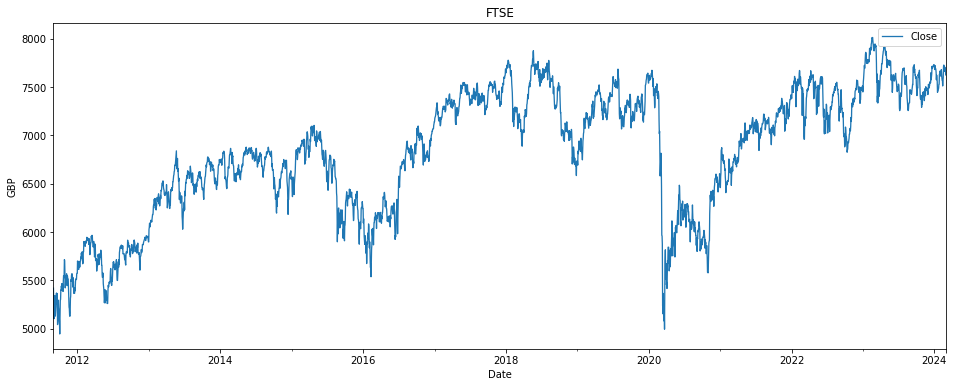

In [84]:
# Plot FTSE close price
sheet_2_intep.plot(y='Close',x='Date',figsize=(16, 6), linewidth=1.3)
plt.xlabel('Date')
plt.ylabel('GBP')
plt.title('FTSE')
plt.legend()
plt.show()

## Sheet3-GBP USD

In [85]:
print(sheet_3.columns)
print(" \nCount total NaN at each column in a DataFrame : \n\n", sheet_3.isnull().sum()) 
print(sheet_3.info())

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')
 
Count total NaN at each column in a DataFrame : 

 Date         0
Open         4
High         4
Low          4
Close        4
Adj Close    4
Volume       4
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3262 entries, 0 to 3261
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       3262 non-null   datetime64[ns]
 1   Open       3258 non-null   float64       
 2   High       3258 non-null   float64       
 3   Low        3258 non-null   float64       
 4   Close      3258 non-null   float64       
 5   Adj Close  3258 non-null   float64       
 6   Volume     3258 non-null   float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 178.5 KB
None


In [86]:
# Correlation between different feature
round(sheet_3[['Open', 'High', 'Low', 'Close']].corr(),2)

,Open,High,Low,Close
Open,1.00,1.00,0.99,1.00
High,1.00,1.00,0.99,1.00
Low,0.99,0.99,1.00,0.99
Close,1.00,1.00,0.99,1.00


## Sheet4-Gold in USD

In [87]:
print(sheet_4.columns)
print(" \nCount total NaN at each column in a DataFrame : \n\n", sheet_2.isnull().sum()) 
print(sheet_4.info())
# Change features Datatype
for column in ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']:
    sheet_4[column] = pd.to_numeric(sheet_4[column],errors = 'coerce')
sheet_4['Date'] = pd.to_datetime(sheet_4['Date'], infer_datetime_format=True)
print(sheet_4.info())

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')
 
Count total NaN at each column in a DataFrame : 

 Date      0
Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3146 entries, 0 to 3145
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       3146 non-null   datetime64[ns]
 1   Open       3146 non-null   object        
 2   High       3146 non-null   object        
 3   Low        3146 non-null   object        
 4   Close      3146 non-null   object        
 5   Adj Close  3146 non-null   object        
 6   Volume     3146 non-null   object        
dtypes: datetime64[ns](1), object(6)
memory usage: 172.2+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3146 entries, 0 to 3145
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     -----------

In [88]:
# Correlation between different feature
round(sheet_4[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']].corr(),2)

,Open,High,Low,Close,Adj Close,Volume
Open,1.00,1.00,1.00,1.00,1.00,-0.02
High,1.00,1.00,1.00,1.00,1.00,-0.02
Low,1.00,1.00,1.00,1.00,1.00,-0.02
Close,1.00,1.00,1.00,1.00,1.00,-0.02
Adj Close,1.00,1.00,1.00,1.00,1.00,-0.02
Volume,-0.02,-0.02,-0.02,-0.02,-0.02,1.00


In [89]:
# Interpolate for any missing in "sheet_4" and create new sheet "sheet_4_intep"
sheet_4_intep=interp(sheet_4,['Open', 'High', 'Low','Close','Volume'])
sheet_4_intep.head()

,Open,High,Low,Close,Volume,Date
0,1828.60,1884.2,1828.6,1873.7,442.0,2011-09-01
1,1857.45,1897.9,1846.3,1871.8,489.0,2011-09-02
2,1886.30,1911.6,1864.0,1869.9,536.0,2011-09-05
3,1868.90,1873.7,1792.8,1814.2,470.0,2011-09-06
4,1839.30,1870.0,1835.0,1854.4,142.0,2011-09-07


## Sheet5-Crude Futures

In [90]:
print(sheet_5.columns)
print(" \nCount total NaN at each column in a DataFrame : \n\n", sheet_5.isnull().sum()) 
print(sheet_5.info())
for column in ['Open', 'High', 'Low', 'Close', 'Adj_Close', 'Volume']:
    sheet_5[column] = pd.to_numeric(sheet_5[column],errors = 'coerce')
sheet_5['Date'] = pd.to_datetime(sheet_5['Date'], infer_datetime_format=True)
print(sheet_5.info())

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj_Close', 'Volume'], dtype='object')
 
Count total NaN at each column in a DataFrame : 

 Date         0
Open         0
High         0
Low          0
Close        0
Adj_Close    0
Volume       0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3137 entries, 0 to 3136
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       3137 non-null   datetime64[ns]
 1   Open       3137 non-null   object        
 2   High       3137 non-null   object        
 3   Low        3137 non-null   object        
 4   Close      3137 non-null   object        
 5   Adj_Close  3137 non-null   object        
 6   Volume     3137 non-null   object        
dtypes: datetime64[ns](1), object(6)
memory usage: 171.7+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3137 entries, 0 to 3136
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype    

In [91]:
# Correlation between different feature
round(sheet_5[['Open', 'High', 'Low', 'Close', 'Adj_Close', 'Volume']].corr(),2)

,Open,High,Low,Close,Adj_Close,Volume
Open,1.00,1.00,1.00,1.00,1.00,-0.57
High,1.00,1.00,1.00,1.00,1.00,-0.57
Low,1.00,1.00,1.00,1.00,1.00,-0.58
Close,1.00,1.00,1.00,1.00,1.00,-0.58
Adj_Close,1.00,1.00,1.00,1.00,1.00,-0.58
Volume,-0.57,-0.57,-0.58,-0.58,-0.58,1.00


In [92]:
# Interpolate for any missing in "sheet_5" and create new sheet "sheet_5_intep"
sheet_5_intep=interp(sheet_5,['Open', 'High', 'Low','Close','Volume'])
print(len(sheet_5_intep))
sheet_5_intep.head()

3262


,Open,High,Low,Close,Volume,Date
0,112.05,113.59,111.41,112.33,1048.0,2011-09-01
1,111.49,113.29,111.13,112.61,959.5,2011-09-02
2,110.93,112.99,110.85,112.89,871.0,2011-09-05
3,113.07,115.76,113.07,115.80,1062.0,2011-09-06
4,115.58,116.49,114.20,114.55,770.0,2011-09-07


## Sheet6-GBP Libor

In [93]:
print("The start date is",sheet_6['Date'].values[0],"and the end date is",sheet_6['Date'].values[-1])
print(sheet_6.columns)
print(" \nCount total NaN at each column in a DataFrame : \n\n", sheet_6.isnull().sum()) 
print(sheet_6.info())

The start date is 01.09.2011 and the end date is 01.03.2024
Index(['Date', '3M'], dtype='object')
 
Count total NaN at each column in a DataFrame : 

 Date    0
3M      0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3157 entries, 0 to 3156
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    3157 non-null   object 
 1   3M      3157 non-null   float64
dtypes: float64(1), object(1)
memory usage: 49.5+ KB
None


In [94]:
# Sheet 6 involve change in Date format from 01.09.2011 to 2011-09-01
def changedate_formate(df):
    split = df.split('.')
    a = split[0]
    b = split[1]
    c = split[2]
    return c+'.'+b+'.'+a

In [95]:
# Change date format and create a new sheet "sheet_6_"
sheet_6_=sheet_6.copy()
date_=sheet_6_['Date'].values
rev_date_=[]
for i in date_:
    rev_date_.append(changedate_formate(i))
sheet_6_['Date']=rev_date_
sheet_6_['Date'] = pd.to_datetime(sheet_6_['Date'], infer_datetime_format=True)

In [96]:
# Interpolate for any missing in "sheet_6_" and create new sheet "sheet_6_intep"
sheet_6_intep=interp(sheet_6_,['3M'])
print(sheet_6_intep.head())

        3M       Date
0  0.88813 2011-09-01
1  0.88875 2011-09-02
2  0.89031 2011-09-05
3  0.89344 2011-09-06
4  0.89656 2011-09-07


## Get Technical Indicators for FTSE100 Close price

Many investors use technical indicators of a stock to decide whether to invest or not. Thus, we use various technical indicators as independent variables for our model. The list includes:

- Moving averages (SMA) : When price action tends to stay above the moving average, it signals that price is in a general UPTREND. If price action tends to stay below the moving average, then it indicates that it is in a DOWNTREND. In an uptrend, the “faster” moving average should be above the “slower” moving average, and for a downtrend, vice versa. The input is window size of moving average.
- Moving averages convergence divergences (MACD)

Fast Line: The "fast" component of the MACD refers to the 12-period Exponential Moving Average (EMA). This EMA is faster because it considers a shorter time frame compared to the "slow" component.

Slow Line: The "slow" component of the MACD refers to the 26-period Exponential Moving Average (EMA). It's called "slow" because it takes into account a longer time frame compared to the "fast" line.

Signal Line: The "signal" line is derived from the MACD line itself. It's often a 9-period Exponential Moving Average of the MACD line. This signal line helps traders identify potential crossovers and confirm trends indicated by the MACD line.

The MACD line is the difference between the fast and slow EMAs (MACD = 12-period EMA - 26-period EMA).

The Signal line is a 9-period EMA of the MACD line.

Crossovers between the MACD line and the Signal line are often used as buy or sell signals in technical analysis. For example, when the MACD line crosses above the Signal line, it might be considered a bullish signal, indicating a potential uptrend, and vice versa.
- Bollinger bands

In ta (technical analysis) library within Pandas, the Bollinger Bands indicator can be calculated using the BollingerBands class. Bollinger Bands are volatility bands placed above and below a moving average. They are based on standard deviations of price movements

'close' represents the column in your DataFrame that contains the closing prices.

'window' is the period for the moving average used to calculate the middle Bollinger Band.

'window_dev' represents the number of standard deviations to be used for the upper and lower bands.

Window (Period): This parameter determines the number of periods used in the moving average calculation for the middle Bollinger Band. Common values for the window can range from 20 to 50 periods, but it's often adapted to the timeframe you're working with. For daily data, a window of 20 periods is quite common, but for shorter timeframes like intraday data, you might consider shorter windows (e.g., 10 or 14 periods) to capture more recent price movements.

Window Deviations: This parameter sets the number of standard deviations from the moving average used to calculate the upper and lower bands. Commonly, two standard deviations are used (window_dev = 2), but this can be adjusted depending on the level of volatility in the market. Higher deviations widen the bands, which might capture more price movements but can potentially result in fewer signals.

- Exponential moving average (EMA). The input is window size of Exponential moving average.

The following code gets the technical indicators and plots their information

In [97]:
import copy
df = copy.deepcopy(sheet_2_intep) # Copy sheet "sheet_2_intep" in another dataframe df
df.head()

,Open,High,Low,Close,Volume,Date
0,5394.5,5449.7,5346.7,5418.7,975363800.0,2011-09-01
1,5418.7,5418.7,5258.5,5292.0,823930000.0,2011-09-02
2,5292.0,5292.0,5097.7,5102.6,788821300.0,2011-09-05
3,5102.6,5190.3,5086.8,5156.8,946079100.0,2011-09-06
4,5156.8,5322.2,5156.8,5318.6,837910500.0,2011-09-07


In [98]:
# Parameters related to Technical indicators plot
price_size = (16, 8)
ind_size = (16, 2)
recent = 500
half_of_recent = int(0.5 * recent)
last_ = df.shape[0]
recent_startdate = df.tail(recent)['Date'].values[0]
recent_enddate = df.tail(recent)['Date'].values[-1]
print(f"{df.shape} from {recent_startdate} to {recent_enddate}\n{df.describe()}")

(3262, 6) from 2022-04-04T00:00:00.000000000 to 2024-03-01T00:00:00.000000000
             Open         High          Low        Close        Volume
count  3262.00000  3262.000000  3262.000000  3262.000000  3.262000e+03
mean   6822.68324  6862.311168  6782.914651  6823.539635  7.817403e+08
std     654.64989   649.458090   660.702477   654.420114  2.665043e+08
min    4944.40000  5075.500000  4868.600000  4944.400000  8.378200e+06
25%    6365.30000  6401.725000  6319.425000  6365.425000  6.317065e+08
50%    6909.10000  6948.900000  6859.750000  6910.400000  7.452704e+08
75%    7377.67500  7414.910000  7341.325000  7378.375000  8.761316e+08
max    8014.30000  8047.100000  7995.500000  8014.300000  3.761301e+09


In [99]:
ticker='FTSE'
def ctitle(indicator_name, ticker, length=100):
    return f"{ticker}: {indicator_name} from {recent_startdate} to {recent_startdate} ({length})"

closedf = df['Close']
datedf=df['Date']

In [100]:
def cscheme(colors):
    aliases = {
        'BkBu': ['black', 'blue'],
        'gr': ['green', 'red'],
        'grays': ['silver', 'gray'],
        'mas': ['black', 'green', 'orange', 'red'],
    }
    aliases['default'] = aliases['gr']
    return aliases[colors]

def machart(kind, fast, medium, slow, append=True, last=last_, figsize=price_size, colors=cscheme('mas')):
    title = ctitle(f"{kind.upper()}s", ticker=ticker, length=last)
    ma1 = df.ta(kind=kind, length=fast, append=append,fillna=0)
    ma2 = df.ta(kind=kind, length=medium, append=append,fillna=0)
    ma3 = df.ta(kind=kind, length=slow, append=append,fillna=0)
    
    madf = pd.concat([datedf,closedf, df[[ma1.name, ma2.name, ma3.name]]], axis=1, sort=False).tail(last)
    madf.plot(x='Date',figsize=figsize, title=title, color=colors, grid=True) 
#     madf.set_index(['date'], inplace=True)

def volumechart(kind, length=10, last=last_, figsize=ind_size, alpha=0.7, colors=cscheme('gr')):
    title = ctitle("Volume", ticker=ticker, length=last)
    volume = pd.DataFrame({'V+': volumedf[closedf > opendf], 'V-': volumedf[closedf < opendf]}).tail(last)
    
    volume.plot(kind='bar', figsize=figsize, width=0.5, color=colors, alpha=alpha, stacked=True)
    vadf = df.ta(kind=kind, close=volumedf, length=length).tail(last)
    vadf.plot(figsize=figsize, lw=1.4, color='black', title=title, rot=45, grid=True)

In [101]:
def TechInd(df):
    # Exponential moving average (EMA)
    machart('ema', 7, 14, 21, last=recent)
    # Simple Moving Average (SMA)
    matype = 'sma'
    fast_length = 7
    medfast_length = 14
    slow_length = 21
    machart(matype, fast_length, medfast_length, slow_length, last=half_of_recent)
    # Cumulative Log Return
    clr_ma_length = 8
    clrdf = df.ta.log_return(cumulative=True, append=True,fillna=0)
    clrmadf = ta.ema(clrdf, length=clr_ma_length)
    qqdf = pd.DataFrame({f"{clrdf.name}": clrdf, f"{clrmadf.name}({clrdf.name})": clrmadf})
    qqdf_ = pd.concat([datedf, qqdf], axis=1, sort=False).tail(recent)
    qqdf_.plot(x='Date',figsize=ind_size, color=cscheme('BkBu'), linewidth=1, title=ctitle(clrdf.name, ticker=ticker, length=recent), grid=True)
    # MACD
    macddf = df.ta.macd(fast=12, slow=26, signal=9, min_periods=None, append=True,fillna=0)
    df['MACDs_12_26_9']=df['MACDs_12_26_9'].fillna(value=0)
    macddf_ = pd.concat([datedf, macddf[[macddf.columns[0], macddf.columns[2]]]], axis=1, sort=False).tail(recent)
    macddf_.plot(x='Date',figsize=(16, 2), color=cscheme('BkBu'), linewidth=1.3)
#     macddf_ = pd.concat([datedf,closedf, macddf[[macddf.columns[0], macddf.columns[2]]]], axis=1, sort=False).tail(recent)
#     macddf_.plot(x='Date',figsize=(16, 2), color=cscheme('BkBu'), linewidth=1.3)
    # Bollinger bands
    bbandsdf=df.ta.bbands(close='Close', length=20, std=2, append=True,fillna=0)
    bbandsdf_ = pd.concat([datedf,closedf,bbandsdf[[bbandsdf.columns[0], bbandsdf.columns[1],bbandsdf.columns[2]]]], axis=1, sort=False).tail(recent)
    bbandsdf_.plot(x='Date',figsize=(16, 2), color=cscheme('BkBu'), linewidth=1.3)
    return df

,Open,High,Low,Close,Volume,Date,EMA_7,EMA_14,EMA_21,SMA_7,...,SMA_21,CUMLOGRET_1,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9,BBL_20_2.0,BBM_20_2.0,BBU_20_2.0,BBB_20_2.0,BBP_20_2.0
0,5394.5,5449.7,5346.7,5418.7,975363800.0,2011-09-01,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,5418.7,5418.7,5258.5,5292.0,823930000.0,2011-09-02,0.0,0.0,0.0,0.0,...,0.0,-0.023660,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,5292.0,5292.0,5097.7,5102.6,788821300.0,2011-09-05,0.0,0.0,0.0,0.0,...,0.0,-0.060106,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,5102.6,5190.3,5086.8,5156.8,946079100.0,2011-09-06,0.0,0.0,0.0,0.0,...,0.0,-0.049540,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5156.8,5322.2,5156.8,5318.6,837910500.0,2011-09-07,0.0,0.0,0.0,0.0,...,0.0,-0.018646,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


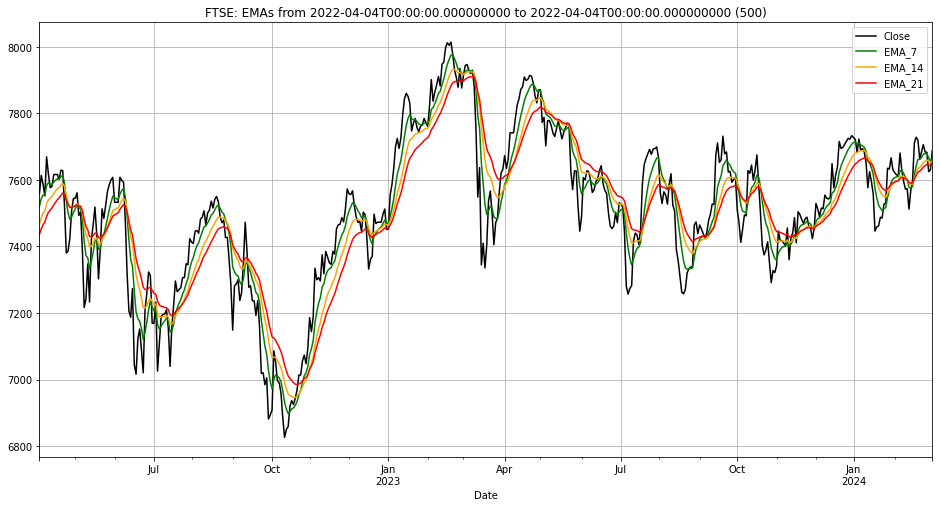

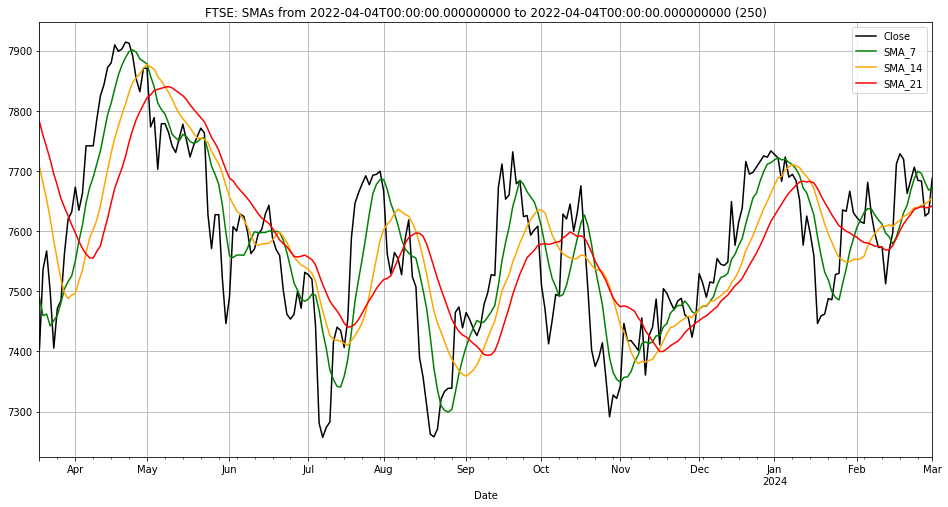

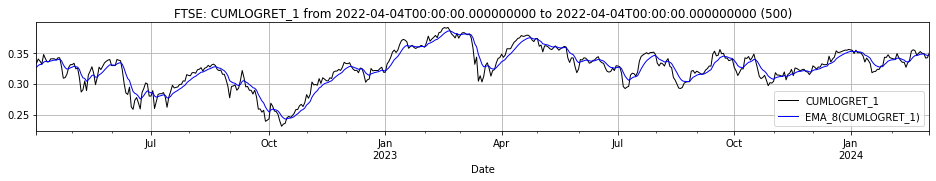

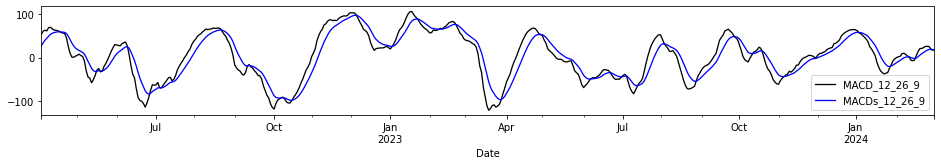

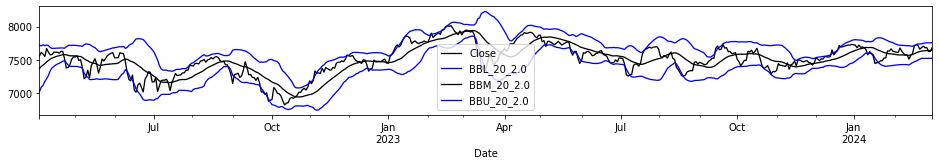

In [102]:
TechInd(df).head()

In [103]:
df.head()

,Open,High,Low,Close,Volume,Date,EMA_7,EMA_14,EMA_21,SMA_7,...,SMA_21,CUMLOGRET_1,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9,BBL_20_2.0,BBM_20_2.0,BBU_20_2.0,BBB_20_2.0,BBP_20_2.0
0,5394.5,5449.7,5346.7,5418.7,975363800.0,2011-09-01,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,5418.7,5418.7,5258.5,5292.0,823930000.0,2011-09-02,0.0,0.0,0.0,0.0,...,0.0,-0.023660,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,5292.0,5292.0,5097.7,5102.6,788821300.0,2011-09-05,0.0,0.0,0.0,0.0,...,0.0,-0.060106,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,5102.6,5190.3,5086.8,5156.8,946079100.0,2011-09-06,0.0,0.0,0.0,0.0,...,0.0,-0.049540,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5156.8,5322.2,5156.8,5318.6,837910500.0,2011-09-07,0.0,0.0,0.0,0.0,...,0.0,-0.018646,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


##  Add Correlated Assets

In [104]:
df['GBP USD '] = list(sheet_3['Close'])
df['Gold in USD close'] = list(sheet_4_intep['Close'])
df['Gold in USD volume'] = list(sheet_4_intep['Volume'])
df['Crude Futures_close'] = list(sheet_5_intep['Close'])
df['Crude Futures_volume'] = list(sheet_5_intep['Volume'])
df['3M'] = list(sheet_6_intep['3M'])

df['FTSE_H-L'] = sheet_2_intep['High']-sheet_2_intep['Low']
df['FTSE_O-C'] = sheet_2_intep['Open']-sheet_2_intep['Close']

df['GBP_USD_H-L'] = sheet_3['High']-sheet_3['Low']
df['GBP_USD_O-C'] = sheet_3['Open']-sheet_3['Close']

df['Gold_H-L'] = sheet_4_intep['High']-sheet_4_intep['Low']
df['Gold_O-C'] = sheet_4_intep['Open']-sheet_4_intep['Close']

df['Crude_H-L'] = sheet_5_intep['High']-sheet_5_intep['Low']
df['Crude_O-C'] = sheet_5_intep['Open']-sheet_5_intep['Close']

In [105]:
df.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Date', 'EMA_7', 'EMA_14',
       'EMA_21', 'SMA_7', 'SMA_14', 'SMA_21', 'CUMLOGRET_1', 'MACD_12_26_9',
       'MACDh_12_26_9', 'MACDs_12_26_9', 'BBL_20_2.0', 'BBM_20_2.0',
       'BBU_20_2.0', 'BBB_20_2.0', 'BBP_20_2.0', 'GBP USD ',
       'Gold in USD close', 'Gold in USD volume', 'Crude Futures_close',
       'Crude Futures_volume', '3M', 'FTSE_H-L', 'FTSE_O-C', 'GBP_USD_H-L',
       'GBP_USD_O-C', 'Gold_H-L', 'Gold_O-C', 'Crude_H-L', 'Crude_O-C'],
      dtype='object')

In [106]:
# Copy "df" to "dataset_total_df" and remove any Nan
dataset_total_df=df.copy()
is_NaN = dataset_total_df.isnull()
row_has_NaN = is_NaN.any(axis=1)
dataset_total_df_clean = dataset_total_df[-row_has_NaN]

In [107]:
dataset_total_df_clean.head()

,Open,High,Low,Close,Volume,Date,EMA_7,EMA_14,EMA_21,SMA_7,...,Crude Futures_volume,3M,FTSE_H-L,FTSE_O-C,GBP_USD_H-L,GBP_USD_O-C,Gold_H-L,Gold_O-C,Crude_H-L,Crude_O-C
0,5394.5,5449.7,5346.7,5418.7,975363800.0,2011-09-01,0.0,0.0,0.0,0.0,...,1048.0,0.88813,103.0,-24.2,0.012277,-0.000132,55.6,-45.10,2.18,-0.28
1,5418.7,5418.7,5258.5,5292.0,823930000.0,2011-09-02,0.0,0.0,0.0,0.0,...,959.5,0.88875,160.2,126.7,0.007678,0.000105,51.6,-14.35,2.16,-1.12
2,5292.0,5292.0,5097.7,5102.6,788821300.0,2011-09-05,0.0,0.0,0.0,0.0,...,871.0,0.89031,194.3,189.4,0.012325,0.000105,47.6,16.40,2.14,-1.96
3,5102.6,5190.3,5086.8,5156.8,946079100.0,2011-09-06,0.0,0.0,0.0,0.0,...,1062.0,0.89344,103.5,-54.2,0.023093,0.000000,80.9,54.70,2.69,-2.73
4,5156.8,5322.2,5156.8,5318.6,837910500.0,2011-09-07,0.0,0.0,0.0,0.0,...,770.0,0.89656,165.4,-161.8,0.008506,0.000382,35.0,-15.10,2.29,1.03


In [108]:
# Make a copy of close price
target_sensor = "Close"
dataset_total_df_clean['Close_copy'] = dataset_total_df_clean[target_sensor]

<b> This is the final dataset that we use, and the features it contains. </b>

In [109]:
dataset_total_df_clean

,Open,High,Low,Close,Volume,Date,EMA_7,EMA_14,EMA_21,SMA_7,...,3M,FTSE_H-L,FTSE_O-C,GBP_USD_H-L,GBP_USD_O-C,Gold_H-L,Gold_O-C,Crude_H-L,Crude_O-C,Close_copy
0,5394.50,5449.70,5346.70,5418.70,9.753638e+08,2011-09-01,0.000000,0.000000,0.000000,0.000000,...,0.88813,103.00,-24.20,0.012277,-0.000132,55.6,-45.10,2.18,-0.28,5418.70
1,5418.70,5418.70,5258.50,5292.00,8.239300e+08,2011-09-02,0.000000,0.000000,0.000000,0.000000,...,0.88875,160.20,126.70,0.007678,0.000105,51.6,-14.35,2.16,-1.12,5292.00
2,5292.00,5292.00,5097.70,5102.60,7.888213e+08,2011-09-05,0.000000,0.000000,0.000000,0.000000,...,0.89031,194.30,189.40,0.012325,0.000105,47.6,16.40,2.14,-1.96,5102.60
3,5102.60,5190.30,5086.80,5156.80,9.460791e+08,2011-09-06,0.000000,0.000000,0.000000,0.000000,...,0.89344,103.50,-54.20,0.023093,0.000000,80.9,54.70,2.69,-2.73,5156.80
4,5156.80,5322.20,5156.80,5318.60,8.379105e+08,2011-09-07,0.000000,0.000000,0.000000,0.000000,...,0.89656,165.40,-161.80,0.008506,0.000382,35.0,-15.10,2.29,1.03,5318.60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3257,7706.28,7710.78,7676.75,7684.30,1.150000e+09,2024-02-26,7678.952018,7656.532535,7642.741512,7699.571429,...,5.32920,34.03,21.98,0.004227,-0.000161,10.6,5.60,2.04,-0.94,7684.30
3258,7684.30,7698.29,7669.71,7683.02,1.060000e+09,2024-02-27,7679.969014,7660.064197,7646.403193,7695.472857,...,5.33000,28.58,1.28,0.003499,0.000000,1.9,1.90,1.64,-1.10,7683.02
3259,7683.02,7693.18,7620.37,7624.98,1.150000e+09,2024-02-28,7666.221760,7655.386304,7644.455630,7680.684286,...,5.32910,72.81,58.04,0.005957,-0.000096,12.2,-3.50,1.68,-0.28,7624.98
3260,7624.98,7677.69,7622.87,7630.02,1.870000e+09,2024-02-29,7657.171320,7652.004130,7643.143300,7667.942857,...,5.32910,54.82,-5.04,0.005302,-0.000113,15.5,-11.40,0.70,0.03,7630.02


In [110]:
features = list(dataset_total_df_clean.columns.difference([target_sensor]))
features

['3M',
 'BBB_20_2.0',
 'BBL_20_2.0',
 'BBM_20_2.0',
 'BBP_20_2.0',
 'BBU_20_2.0',
 'CUMLOGRET_1',
 'Close_copy',
 'Crude Futures_close',
 'Crude Futures_volume',
 'Crude_H-L',
 'Crude_O-C',
 'Date',
 'EMA_14',
 'EMA_21',
 'EMA_7',
 'FTSE_H-L',
 'FTSE_O-C',
 'GBP USD ',
 'GBP_USD_H-L',
 'GBP_USD_O-C',
 'Gold in USD close',
 'Gold in USD volume',
 'Gold_H-L',
 'Gold_O-C',
 'High',
 'Low',
 'MACD_12_26_9',
 'MACDh_12_26_9',
 'MACDs_12_26_9',
 'Open',
 'SMA_14',
 'SMA_21',
 'SMA_7',
 'Volume']

In [111]:
dataset_total_df_clean.to_csv('Processed_data.csv')

In [112]:
# Check corrlelation
cormat = dataset_total_df_clean.corr()
round(cormat,2)

,Open,High,Low,Close,Volume,EMA_7,EMA_14,EMA_21,SMA_7,SMA_14,...,3M,FTSE_H-L,FTSE_O-C,GBP_USD_H-L,GBP_USD_O-C,Gold_H-L,Gold_O-C,Crude_H-L,Crude_O-C,Close_copy
Open,1.00,1.00,1.00,1.00,-0.11,0.95,0.90,0.86,0.94,0.89,...,0.39,-0.23,0.05,-0.07,0.01,-0.29,-0.01,0.13,-0.02,1.00
High,1.00,1.00,1.00,1.00,-0.09,0.95,0.90,0.86,0.94,0.89,...,0.40,-0.20,0.00,-0.07,0.01,-0.28,-0.01,0.14,-0.02,1.00
Low,1.00,1.00,1.00,1.00,-0.13,0.94,0.89,0.86,0.94,0.89,...,0.39,-0.27,-0.01,-0.07,0.02,-0.30,-0.01,0.12,-0.02,1.00
Close,1.00,1.00,1.00,1.00,-0.12,0.94,0.89,0.86,0.94,0.89,...,0.39,-0.24,-0.04,-0.07,0.01,-0.29,-0.01,0.13,-0.02,1.00
Volume,-0.11,-0.09,-0.13,-0.12,1.00,-0.09,-0.09,-0.08,-0.09,-0.08,...,0.02,0.52,0.09,0.11,-0.06,0.20,0.00,0.20,0.01,-0.12
EMA_7,0.95,0.95,0.94,0.94,-0.09,1.00,0.95,0.91,1.00,0.95,...,0.36,-0.20,0.02,-0.06,0.01,-0.31,-0.01,0.12,-0.01,0.94
EMA_14,0.90,0.90,0.89,0.89,-0.09,0.95,1.00,0.96,0.95,1.00,...,0.34,-0.18,0.02,-0.06,0.01,-0.30,0.01,0.12,-0.00,0.89
EMA_21,0.86,0.86,0.86,0.86,-0.08,0.91,0.96,1.00,0.91,0.96,...,0.32,-0.17,0.02,-0.06,0.00,-0.30,-0.03,0.11,-0.01,0.86
SMA_7,0.94,0.94,0.94,0.94,-0.09,1.00,0.95,0.91,1.00,0.95,...,0.36,-0.20,0.03,-0.06,0.01,-0.31,-0.01,0.12,-0.01,0.94
SMA_14,0.89,0.89,0.89,0.89,-0.08,0.95,1.00,0.96,0.95,1.00,...,0.34,-0.17,0.03,-0.06,0.01,-0.30,0.01,0.13,-0.00,0.89


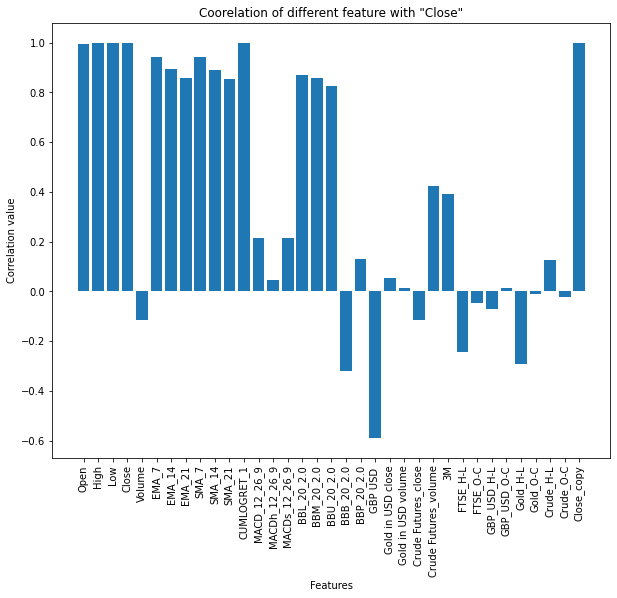

In [113]:
cormat['Close']
plt.figure(figsize=(10, 8))
plt.bar(list(cormat['Close'].keys()), list(cormat['Close']) )
plt.xticks(rotation=90)
plt.ylabel('Correlation value')
plt.xlabel('Features')
plt.title('Coorelation of different feature with "Close"')
plt.show()

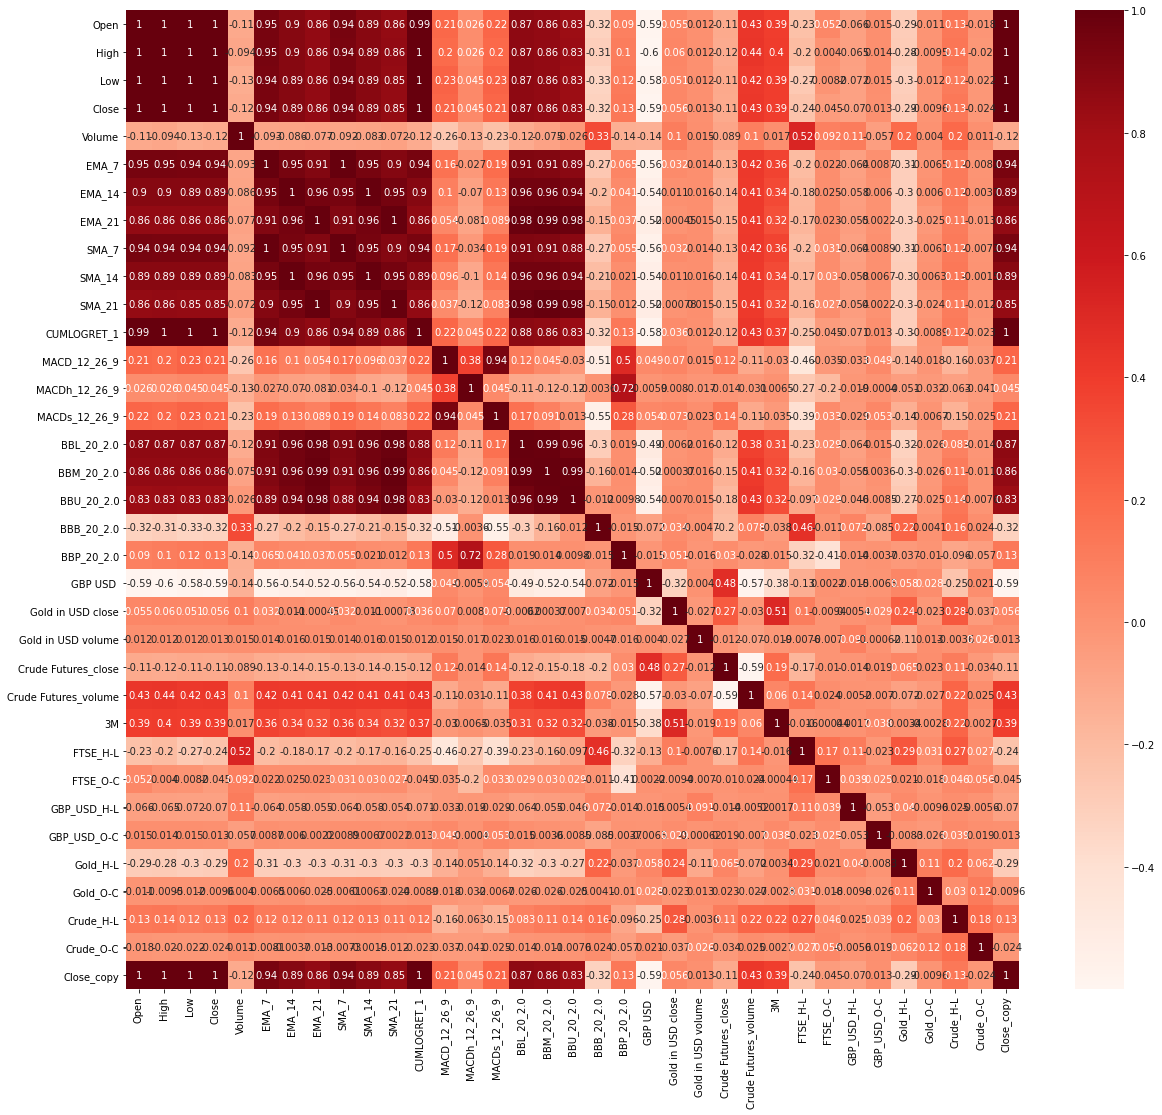

In [114]:
plt.figure(figsize=(20,18))
sns.heatmap(cormat, annot=True, cmap=plt.cm.Reds)
plt.show()